# What neighborhood is best to walk in?

## Group name:
## **W** _on't_
## **A** _ctually_
## **L** _earn_
## **K** _oding_

# Introduction:
Walking is a very enjoyable activity. It gets you places, passes the time, and has various health benefits. Our group decided that the best Pittsburgh neighborhood to walk in is the best neighborhood in Pittsburgh. You may ask, "What makes the best neighborhood to walk in?", "Is it scenery?", "Is it safety?", no and no. The best neighborhood was decided based on what requires the least effort, which was chosen based on the density and steepness of hills, and how annoying it is to drive in, which was chosen based on the prevalence of traffic lights and speed bumps. We chose these metrics because


# The Metrics:

In [28]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import geopandas as gpd
from tqdm import tqdm, notebook
import pickle

In [29]:
# dark mode better
plt.style.use('dark_background')

## Top 5 neighborhoods based on stoplights:

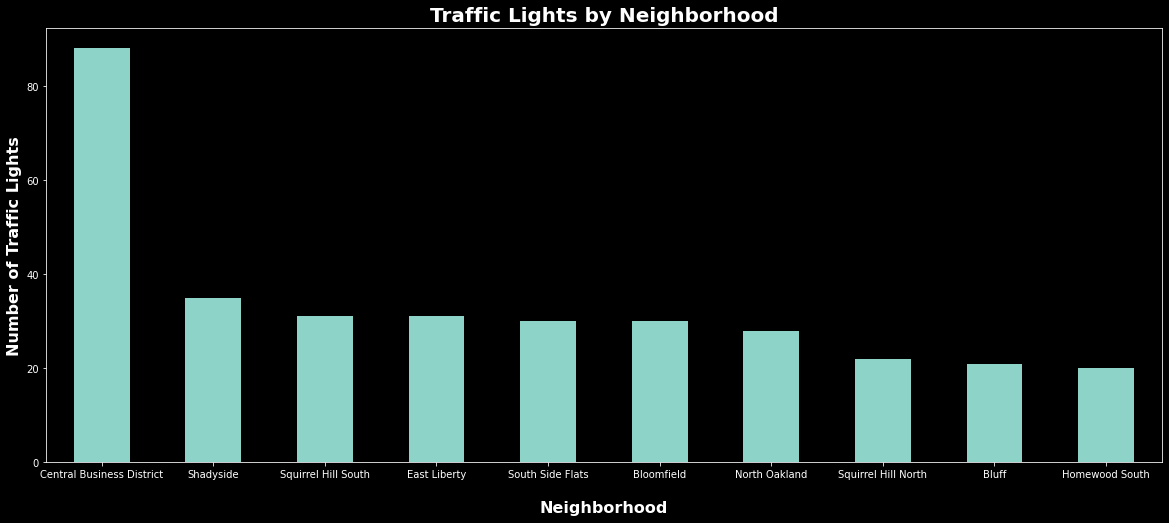

In [161]:
stopLights = pd.read_csv("RedLights.csv")
stopLights = stopLights["neighborhood"].value_counts().sort_values(ascending=False)

axprop = {'weight' : 'bold', 'fontsize' : 16}
titleprop = {'weight' : 'bold', 'fontsize' : 20}
plot = stopLights.head(10).plot(kind='bar', rot=0, figsize = (20,8))
plot.set_xlabel("\nNeighborhood",axprop)  
plot.set_ylabel("Number of Traffic Lights",axprop)
plot.set_title('Traffic Lights by Neighborhood', titleprop)
plt.show()

## Top 5 Neighborhoods based on speed bumps:

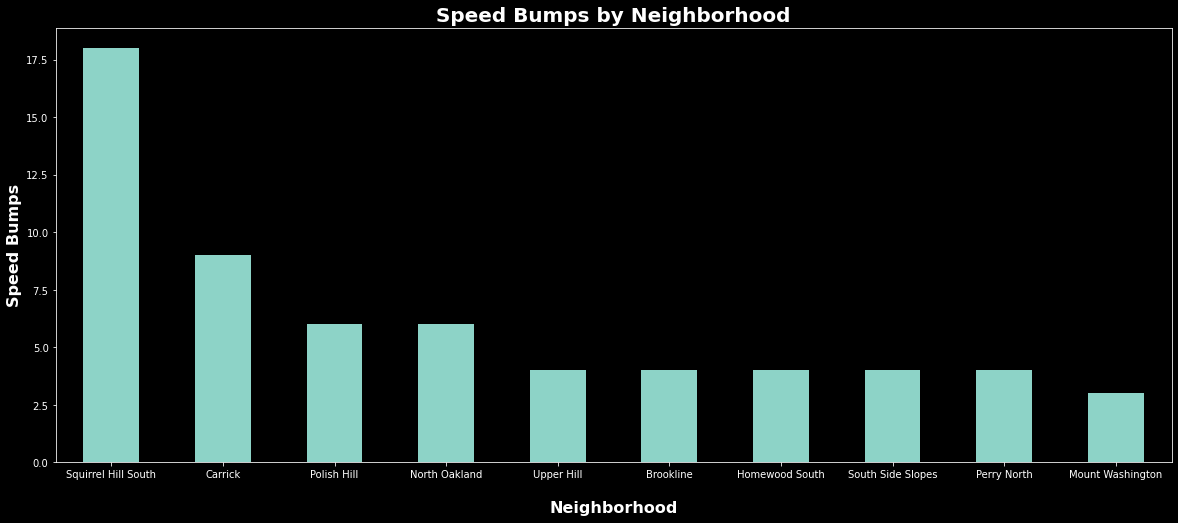

In [160]:
speedBumps = pd.read_csv("SpeedBumps.csv")
speedBumps = speedBumps["neighborhood"].value_counts().sort_values(ascending=False)
plot = speedBumps.head(10).plot(kind='bar', rot=0, figsize = (20,8))

plot.set_xlabel("\nNeighborhood",axprop)
plot.set_ylabel("Speed Bumps",axprop)
plot.set_title('Speed Bumps by Neighborhood', titleprop)
plt.show()

## Top 5 Neighborhoods based on slope

In [18]:
slope = gpd.read_file('./25_Or_Greater_Slope/slope.shp')
hoods = gpd.read_file('./City_of_Pittsburgh_Neighborhoods/City_of_Pittsburgh_Neighborhoods.shp')

### EXPLODE THE DATAFRAME!

Yes, **explode**, a real pandas method

In [168]:
# EXPLODE THE DATADRAME!
slope_exploded = slope.explode()

In [5]:
data = []
pbar = tqdm(total=len(hoods) * len(slope_exploded))
for i1, hood in hoods.iterrows():
    for i2, s in slope_exploded.iterrows():
        if hood['geometry'].intersects(s['geometry']):
            data.append(
                {
                    'geometry': s['geometry'].buffer(0).intersection(hood['geometry'].buffer(0)),
                    'hood_i': i1
                })
        pbar.update(1)
df = gpd.GeoDataFrame(data, columns=['geometry', 'hood_i'])

  2%|▏         | 65162/3554915 [00:07<06:17, 9233.96it/s] 

KeyboardInterrupt: 

  2%|▏         | 66126/3554915 [00:20<06:17, 9233.96it/s]

In [20]:
# load pickled df
with open('df.pickle', 'rb') as file:
    df = pickle.load(file)

In [21]:
df.head()

,geometry,hood_i
0,"POLYGON ((-79.95494 40.44103, -79.95502 40.441...",0
1,"POLYGON ((-79.95445 40.44102, -79.95454 40.441...",0
2,"POLYGON ((-79.95409 40.44058, -79.95424 40.440...",0
3,"POLYGON ((-79.95370 40.44059, -79.95370 40.440...",0
4,"POLYGON ((-79.95364 40.44124, -79.95364 40.441...",0


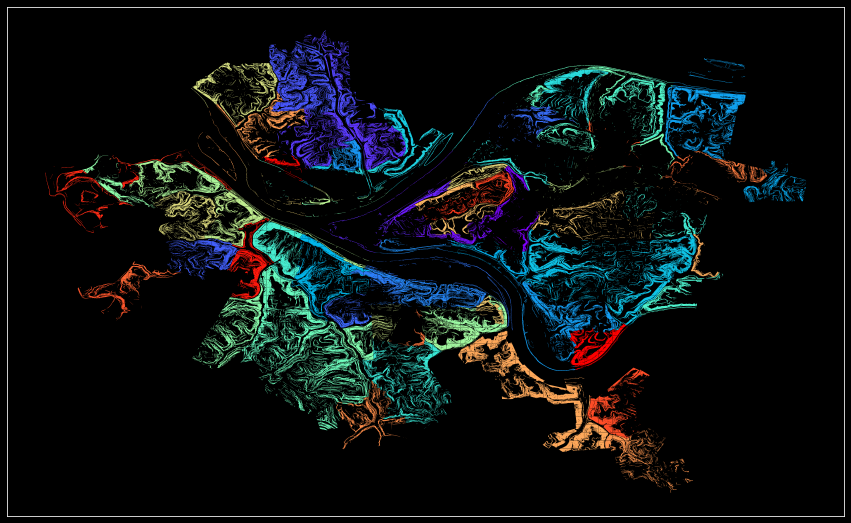

In [164]:
ax = df.plot(
    figsize=(15, 15), 
    column=df['hood_i'],
    cmap='rainbow',
)
plt.tick_params(
    left = False,
    labelleft = False, 
    labelbottom = False, 
    bottom = False
)
plt.show()

In [23]:
area = []
for i in range(91):
    area.append(0)
for i, row in df.iterrows():
    area[row['hood_i']] += row['geometry'].area
d = {
    'name': [],
    'density': [],
}
for i, hood in hoods.iterrows():
    d['name'].append(hood['HOOD'])
    d['density'].append(area[i] / hood['geometry'].area)
density_df = pd.DataFrame(data=d)

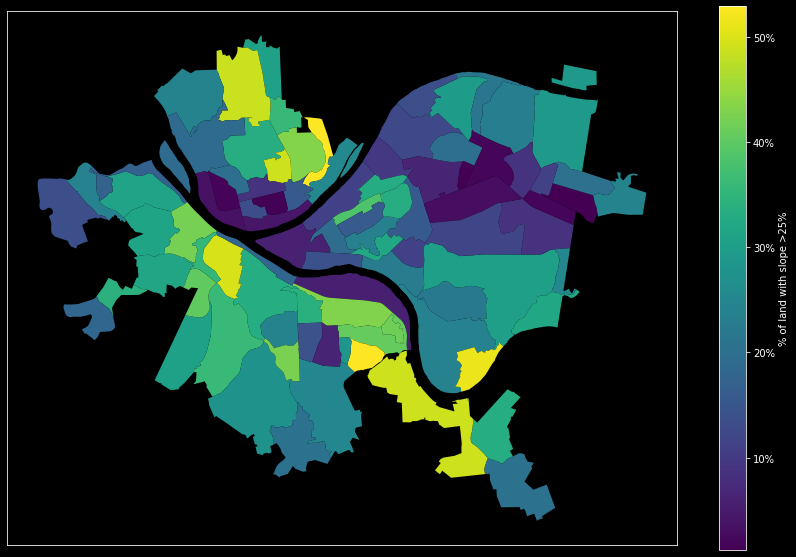

In [165]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
hoods.plot(
    ax=ax,
    column=density_df['density'],
    legend=True,
    legend_kwds={
        'label': "% of land with slope >25%",
        'orientation': 'vertical', 
        'format': mtick.PercentFormatter(1.0),
    },
    cmap='viridis',
)
plt.tick_params(
    left = False,
    labelleft = False, 
    labelbottom = False, 
    bottom = False
)
plt.show()

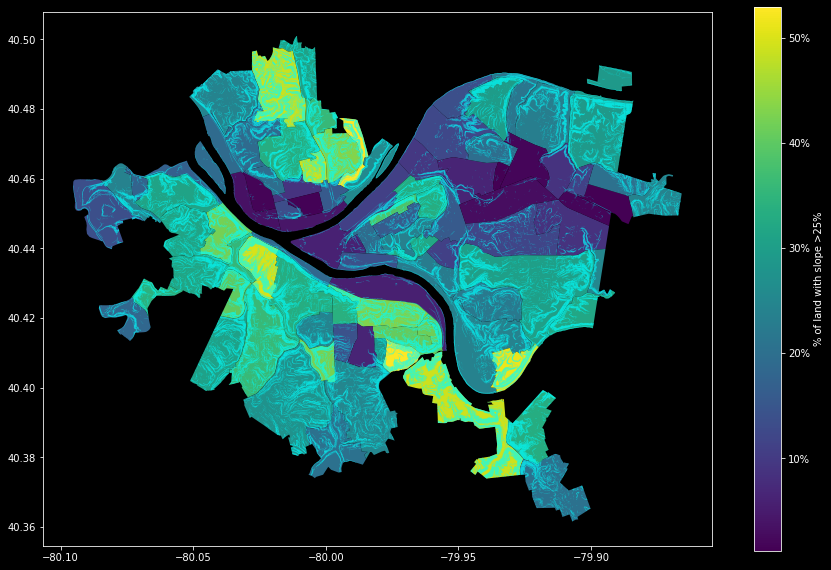

In [25]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
hoods.plot(
    ax=ax,
    column=density_df['density'],
    legend=True,
    legend_kwds={
        'label': "% of land with slope >25%",
        'orientation': 'vertical', 
        'format': mtick.PercentFormatter(1.0),
    },
    cmap='viridis',
)
slope.plot(
    ax=ax,
    alpha=.7,
    color='cyan',
)
plt.tick_params(
    left = False,
    labelleft = False, 
    labelbottom = False, 
    bottom = False
)
plt.show()

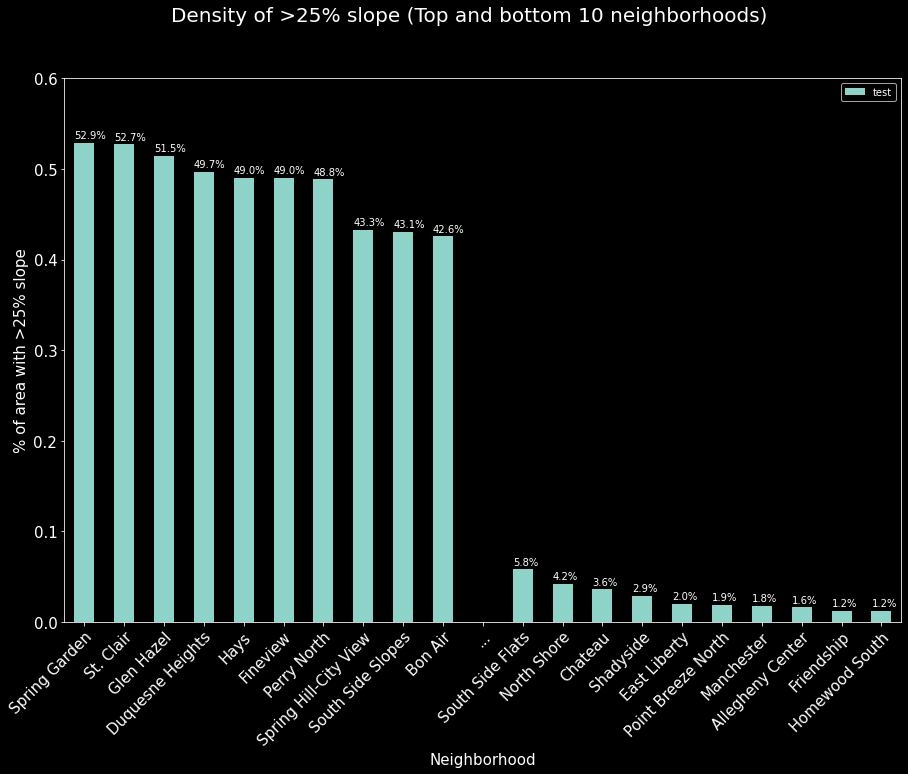

In [26]:
top_bottom_ten = pd.concat(
    (
        density_df.sort_values(by='density', ascending=False)[:10],
        pd.DataFrame({'name': ['...'], 'density': [0]}),
        density_df.sort_values(by='density', ascending=False)[-10:]
    ),
)
fig, ax = plt.subplots()
top_bottom_ten.plot.bar(
    ax=ax,
    x='name', 
    y='density', 
    label='test', 
    figsize=(15,10),
    ylim=(0, .6),
    fontsize=15
)
fig.suptitle('Density of >25% slope (Top and bottom 10 neighborhoods)', fontsize=20)
ax.set_xlabel('Neighborhood', fontsize=15)
ax.set_ylabel('% of area with >25% slope', fontsize=15)
plt.setp(
    ax.xaxis.get_majorticklabels(), 
    rotation=45, 
    ha='right',
    rotation_mode='anchor',
)
for p in ax.patches:
    if p.get_height() != 0:
        ax.annotate(
            '{:.1%}'.format(p.get_height()), 
            (p.get_x() - 0, p.get_height() + .005),
        )

# Final Combination:

In [126]:
speedBumps_df = pd.DataFrame(speedBumps)
speedBumps.keys
final_data = []
for hood in hoods['HOOD']:
    final_data.append({
        'hood': hood,
        'density': density_df.query('name=="' + hood + '"')['density'].values[0],
        'speedBumps': speedBumps[hood] if hood in speedBumps.keys() else 0,
        'stopLights': stopLights[hood] if hood in stopLights.keys() else 0,
    })
final_data_df = pd.DataFrame(final_data)

In [133]:
final_score = []
for i, row in final_data_df.iterrows():
    final_score.append({
        'hood': row['hood'],
        'score': (row['speedBumps'] + row['stopLights']) / (row['density'] * 10)
    })
final_score_df = pd.DataFrame(final_score)

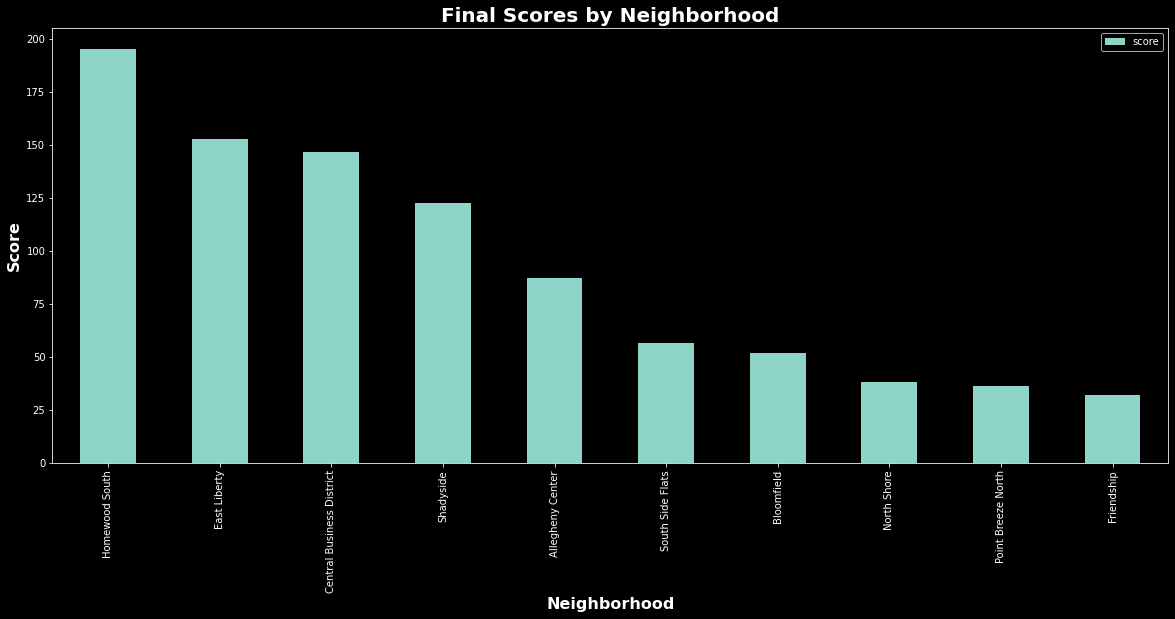

In [167]:
plot = final_score_df.sort_values(by='score', ascending=False).head(10).plot.bar(
    x='hood', 
    figsize=(20,8),
)
plot.set_xlabel('Neighborhood', axprop)
plot.set_ylabel('Score', axprop)
plot.set_title('Final Scores by Neighborhood', titleprop)
plt.show()

# Conclusion: